In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
import fitz
from fitz import Rect
from PIL import Image
import sys, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

from pdf_scraper.block_utils import identify_dual_column, get_block_text, sort_dual_column_blocks, clean_blocks
from pdf_scraper.doc_utils   import open_exam, get_doc_line_df, identify_section_headers, identify_text_headers, get_path_from_doc
from pdf_scraper.doc_utils   import identify_footers, identify_instructions, identify_subtitles, identify_subsubtitles
from pdf_scraper.draw_utils  import draw_rectangles_on_page, draw_rectangles_for_all_pages
from pdf_scraper.line_utils  import get_line_df, print_line_table, get_all_lines, line_is_empty, re_box_line
from pdf_scraper.line_utils  import is_buffered_line, clean_line_df, get_df_bbox
from pdf_scraper.doc_utils   import get_images, filter_images, get_raw_lines, assign_in_image_captions, identify_vertical_captions
from pdf_scraper.line_utils  import get_line_text
from pdf_scraper.clustering.cluster_utils import find_y0_dL

from pdf_scraper.image_utils import show_image, show_all_imgs

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", 200)

In [61]:
def enrich_doc_df_with_images(df, images):
    poo = {val: [ img["bbox"][i] for img in images ] for i, val in enumerate(["x0","y0","x1","y1"])}
    img_dict = { }
    for i, coord in enumerate(["x0","y0","x1","y1"]):
        img_dict[coord]   = [ img["bbox"][i] for img in images ]
    img_dict["page"]  = [ img["page"]   for img in images]
    img_dict["image"] = [1]*len(images)
    img_df = pd.DataFrame(img_dict)    
    rich_df = pd.concat([df, img_df],ignore_index=True).sort_values(by=["page","y0"],ignore_index=True)
    
    return rich_df

In [62]:
year=2019
doc    = open_exam(year, "english", "al",1)
df     = get_doc_line_df(doc)

images = get_images(doc)
images = filter_images(images)
assign_in_image_captions(df,images)

doc_width     = doc[0].rect.width
middle        = doc_width/2
standard_font = df.mode_font.mode()[0]
median_font   = df.font_size.median()


df = clean_line_df(df)
identify_footers(df)
identify_instructions(df)
identify_section_headers(df)
identify_text_headers(df, doc_width)
identify_subtitles(df, doc_width)
identify_subsubtitles(df,doc_width)


for image in images:
    if image["page"] <2 or image["page"] >8:
        continue
    identify_vertical_captions(df, image)

page: 6


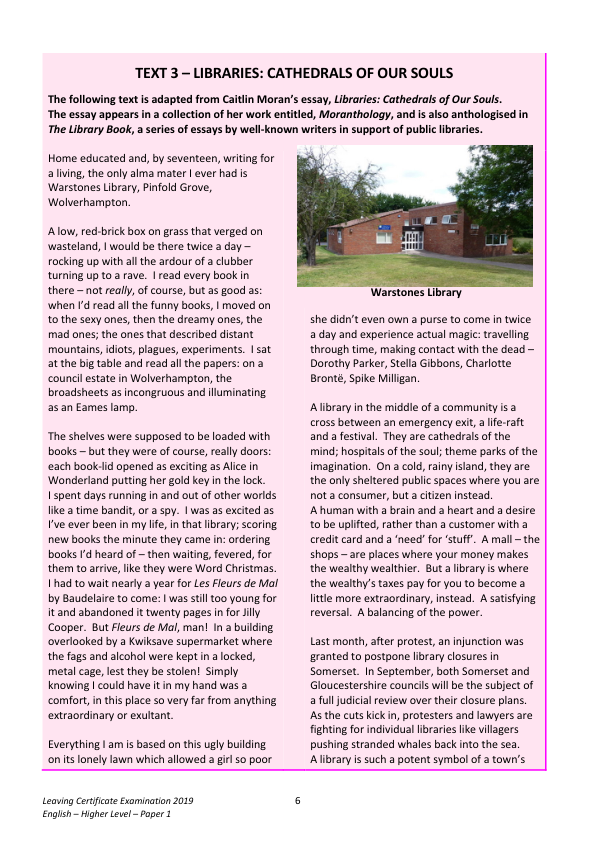

In [63]:
page = np.unique(df[df.caption2==1].page)[0]
page_df = df.loc[df.page==page, ["text", 'x0', 'y0', 'x1', 'y1', "page"]].copy()
doc_page = doc[int(page-1)]

pix = doc_page.get_pixmap(matrix=fitz.Matrix(1, 1))  # scale=2 for higher resolution
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
print(f"page: {page}")
display(img)

# Enrich doc_df with image information

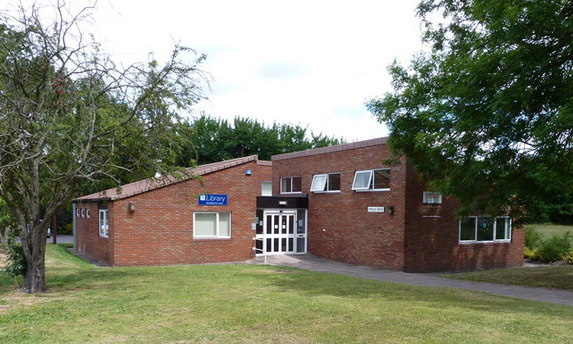

In [64]:
page_df     = df[df.page==page]
page_images = [image for image in images if image["page"]==page]
show_image(page_images[0])

In [65]:
page_df = enrich_doc_df_with_images(page_df,page_images)
page_df["dL"] = page_df.y0.diff()
page_df[['x0', 'y0', 'x1', 'y1', 'mode_font',  'text', 'font_size', 'image', 'page', 'counts']].head(40)

x0     y0     x1     y1     mode_font  \
0  135.24  65.98 456.68  82.00  Calibri-Bold   
1   47.94  94.50 510.43 106.50  Calibri-Bold   
2   47.94 109.14 530.83 121.14  Calibri-Bold   
3   47.94 123.78 485.53 135.78  Calibri-Bold   
4  297.72 145.62 532.50 286.62           NaN   
5   47.94 153.12 277.09 165.12       Calibri   
6   47.94 167.76 250.21 179.76       Calibri   
7   47.94 182.40 214.81 194.40       Calibri   
8   47.94 197.04 133.57 209.04       Calibri   
9   47.94 226.32 265.51 238.32       Calibri   
10  47.94 241.02 253.15 253.02       Calibri   
11  47.94 255.66 255.67 267.66       Calibri   
12  47.94 270.30 251.95 282.30       Calibri   
13  47.94 284.94 264.85 296.94       Calibri   
14 370.68 287.46 464.24 299.46  Calibri-Bold   
15  47.94 299.58 273.61 311.58       Calibri   
16  47.94 314.22 265.33 326.22       Calibri   
17 310.20 314.22 536.53 326.22       Calibri   
18  47.94 328.86 256.15 340.86       Calibri   
19 310.20 328.86 531.73 340.86       Calibri   
20  47.94 343.56 273.67 355.56       Calibri   
21 310.20 343.56 536.65 355.56       Calibri   
22 310.20 358.20 514.21 370.20       Calibri   
23  47.94 358.20 266.23 370.20       Calibri   
24  47.94 372.84 234.79 384.84       Calibri   
25 310.20 372.84 422.65 384.84       Calibri   
26  47.94 387.48 268.75 399.48       Calibri   
27 310.20 402.12 519.01 414.12       Calibri   
28  47.94 402.12 140.53 414.12       Calibri   
29 310.20 416.76 526.63 428.76       Calibri   
30 310.20 431.40 513.25 443.40       Calibri   
31  47.94 431.40 272.89 443.40       Calibri   
32  47.94 446.10 273.97 458.10       Calibri   
33 310.20 446.10 540.43 458.10       Calibri   
34 310.20 460.74 532.69 472.74       Calibri   
35  47.94 460.74 261.01 472.74       Calibri   
36 310.20 475.38 542.17 487.38       Calibri   
37  47.94 475.38 276.31 487.38       Calibri   
38  47.94 490.02 279.07 502.02       Calibri   
39 310.20 490.02 533.74 502.02       Calibri   

                                                                                                  text  \
0                                                         TEXT 3 – LIBRARIES: CATHEDRALS OF OUR SOULS    
1     The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.      
2   The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in    
3          The Library Book, a series of essays by well‐known writers in support of public libraries.    
4                                                                                                  NaN   
5                                                        Home educated and, by seventeen, writing for    
6                                                         a living, the only alma mater I ever had is    
7                                                                   Warstones Library, Pinfold Grove,    
8                                                                                      Wolverhampton.    
9                                                        A low, red‐brick box on grass that verged on    
10                                                          wasteland, I would be there twice a day –    
11                                                        rocking up with all the ardour of a clubber    
12                                                        turning up to a rave.  I read every book in    
13                                                     there – not really, of course, but as good as:    
14                                                                                  Warstones Library    
15                                                      when I’d read all the funny books, I moved on    
16                                                        to the sexy ones, then the dreamy ones, the    
17                                                      she didn’t even own a purse to come in twice     
18                      

# Basic dbscan on X0 and Y0

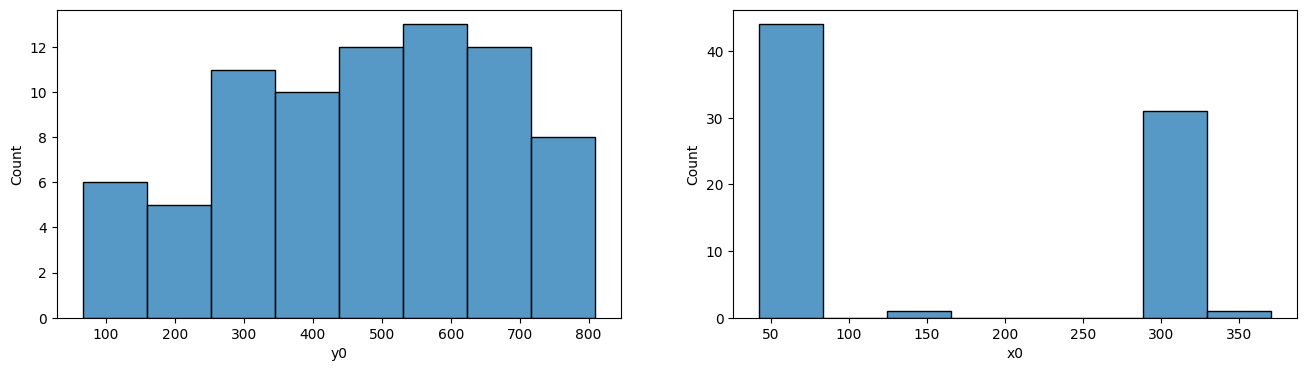

In [66]:
fig, axes = plt.subplots(1,2,figsize=(16,4))

sns.histplot(page_df.y0,ax=axes[0]);
sns.histplot(page_df.x0,ax=axes[1]);

## y0 scan

In [67]:
dL_y0 = find_y0_dL(page_df)
scan = DBSCAN(eps=dL_y0*1.15, min_samples=1)
scan.fit(page_df[["y0"]])
page_df["y_cluster"]=scan.labels_
page_df[['x0', 'y0', 'x1', 'y1', 'mode_font',  'text', 'font_size', 'image', 'page', 'counts',"y_cluster"]].head(5)


x0     y0     x1     y1     mode_font  \
0 135.24  65.98 456.68  82.00  Calibri-Bold   
1  47.94  94.50 510.43 106.50  Calibri-Bold   
2  47.94 109.14 530.83 121.14  Calibri-Bold   
3  47.94 123.78 485.53 135.78  Calibri-Bold   
4 297.72 145.62 532.50 286.62           NaN   

                                                                                                 text  \
0                                                        TEXT 3 – LIBRARIES: CATHEDRALS OF OUR SOULS    
1    The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.      
2  The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in    
3         The Library Book, a series of essays by well‐known writers in support of public libraries.    
4                                                                                                 NaN   

   font_size  image  page  counts  y_cluster  
0      16.02      0     6    0.00          0  
1      12.00      0     6    0.00          1  
2      12.00      0     6    0.00          1  
3      12.00      0     6    0.00          1  
4        NaN      1     6     NaN          2

array([99,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4])

In [68]:
# get cluster bboxes
def get_cluster_boxes(df, labels):
    rectangies = []
    clust_labes = np.unique(labels)[1:] if -1 in labels else np.unique(labels)
    for i in clust_labes:
        temp_df = df[df.cluster==i]
        rectangies.append( Rect(get_df_bbox(temp_df)) )
    return rectangies

def get_category_boxes(df, cat):
    rectangies = []
    clust_labes = np.unique(df[cat])[1:] if -1 in df[cat] else np.unique(df[cat])
    for i in clust_labes:
        temp_df = df[df[cat]==i]
        rectangies.append( Rect(get_df_bbox(temp_df)) )
    return rectangies
rectangies = get_category_boxes(page_df, 'y_cluster')

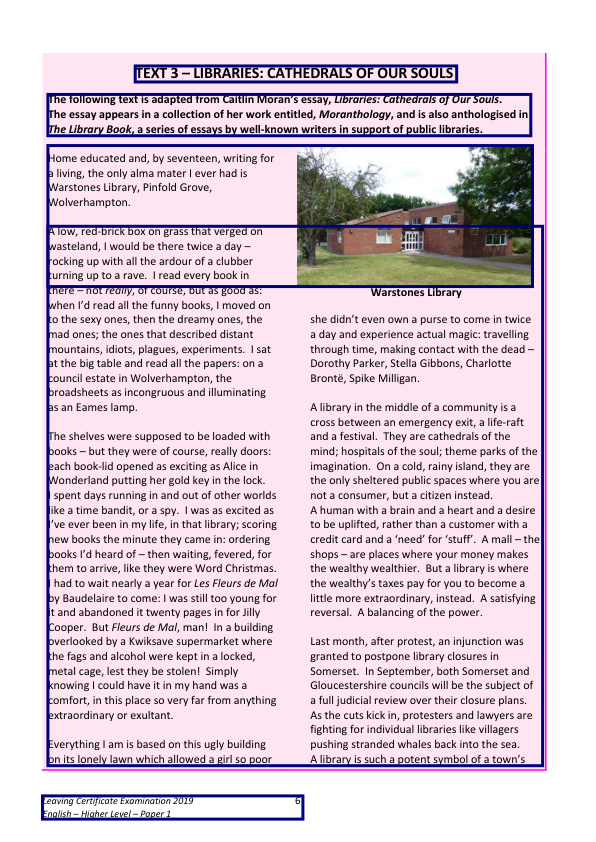

In [11]:
def get_bbox_page_image(doc,  page_number: int, rects: list[Rect], color: tuple[float]=(0,0,0.0) ) -> Image:
    i_p  = int(page_number-1)

    out_doc = fitz.open()
    out_doc.insert_pdf(doc, from_page=i_p, to_page=i_p)
    page = out_doc[0]

    for rect in rects:
        page.draw_rect(rect, color=color, width=3)
    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1))  # scale=2 for higher resolution
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    out_doc.close()

    return img
y_img = get_bbox_page_image(doc, 6, rectangies,color=(0,0,0.5))
display(y_img)

- Because the closeness is only measured with y0, we can see that cluster 2 contains the image, and the lines down to wolverhampton 
- The bbox extracted from this goes to the end of the image, but actually only contains the images and the first paragraph.

## X0 scan

In [12]:
median_w = page_df.w.dropna().map(round).median()

scan = DBSCAN(eps=0.5*median_w, min_samples=1)
scan.fit(page_df[["x0"]])
page_df["x_cluster"]=scan.labels_
page_df[['x0', 'y0', 'w', 'mode_font',  'text', 'font_size', 'image', 'counts',"y_cluster","x_cluster"]].head(5)
scan.labels_

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0])

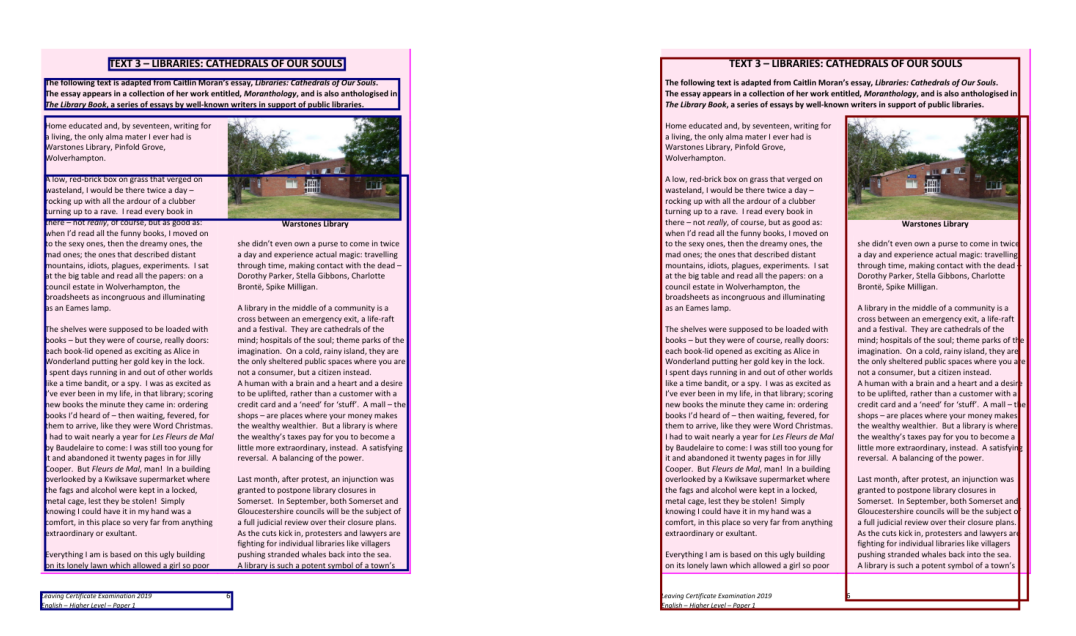

In [13]:
rectangies = get_category_boxes(page_df, 'x_cluster')
x_img = get_bbox_page_image(doc, 6, rectangies,color=(0.5,0,0.0))
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].imshow(y_img); axes[0].axis("off");
axes[1].imshow(x_img); axes[1].axis("off");
plt.subplots_adjust(wspace=0.0)


## Double scan

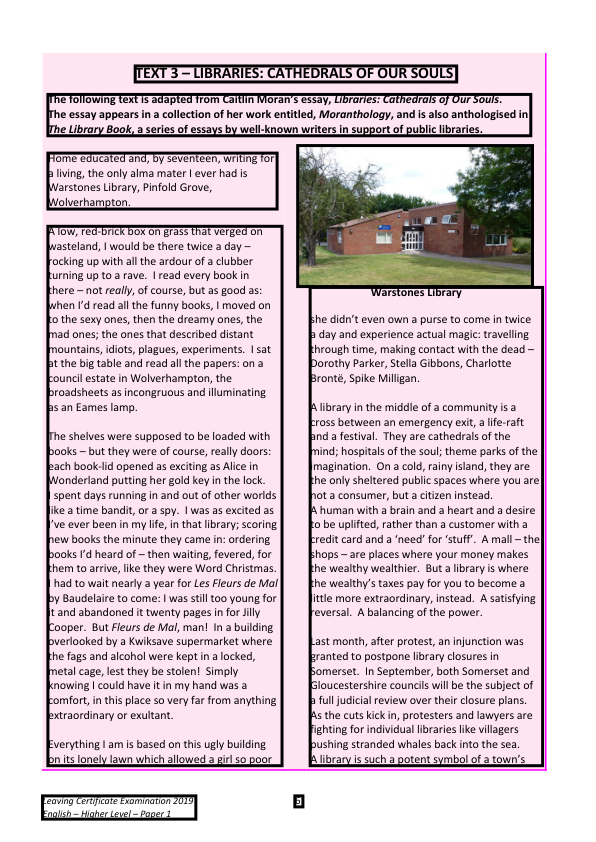

In [ ]:
page_df["cluster_id"] = page_df.groupby(["x_cluster", "y_cluster"]).ngroup()

rectangies = get_category_boxes(page_df, 'cluster_id')
xy_img = get_bbox_page_image(doc, 6, rectangies,color=(0.0,0,0.0))
display(xy_img)

- This is an improved clustering. But we notice that not all pagraphs are separated in y
  - Do another y clustering within each group.
  - The issue is that, when looking only at y, the existence of "A library in the middle" to the right of the paragraph ending in "Eames lamp" gives a false
    impression of contiguity.

In [15]:
labes = []
#labe_count
for i in np.unique(page_df.cluster_id):
    temp_df = page_df[page_df.cluster_id == i]
    scan_y = DBSCAN(eps=dL_y0*1.15, min_samples=1)
    scan_y.fit(temp_df[["y0"]])

    scan_x = DBSCAN(eps=0.5*median_w, min_samples=1)
    scan_x.fit(temp_df[["x0"]])
    #page_df["x_cluster"]=scan.labels_
    #page_df["y_cluster"]=scan.labels_
    #page_df[['x0', 'y0', 'x1', 'y1', 'mode_font',  'text', 'font_size', 'image', 'page', 'counts',"y_cluster"]].head(5)
    if len(np.unique(scan_y.labels_)) >1:
        print(f"Cluster {i} split vertically")

    if len(np.unique(scan_x.labels_)) >1:
        print(f"Cluster {i} split horizontally")

Cluster 3 split vertically
Cluster 6 split vertically


# Hierarchical alternating scan till stability

In [75]:
dirs = (("y0",eps_y0), ("x0",eps_x0))
i_dir = 0
dirs[i_dir][0]

'y0'

Scanning in y0


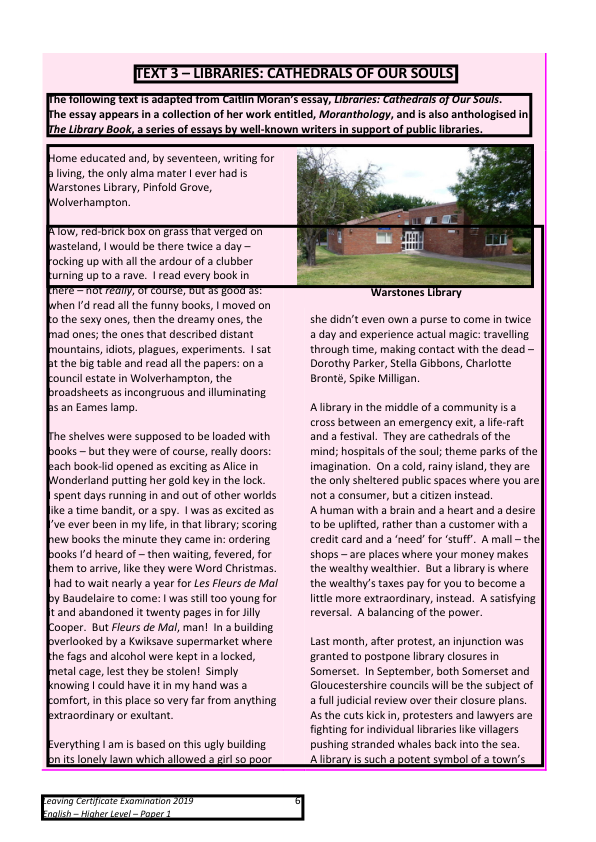

Scanning in y0


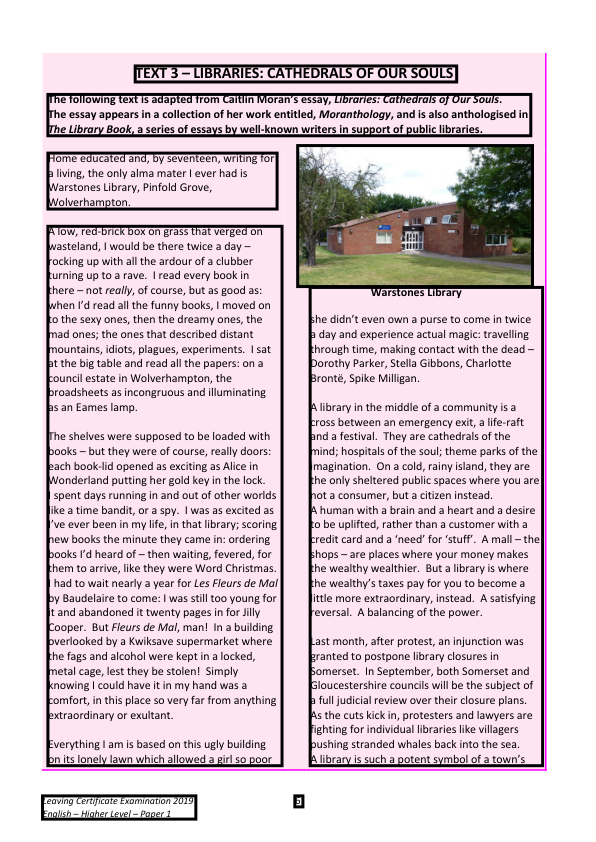

Scanning in x0


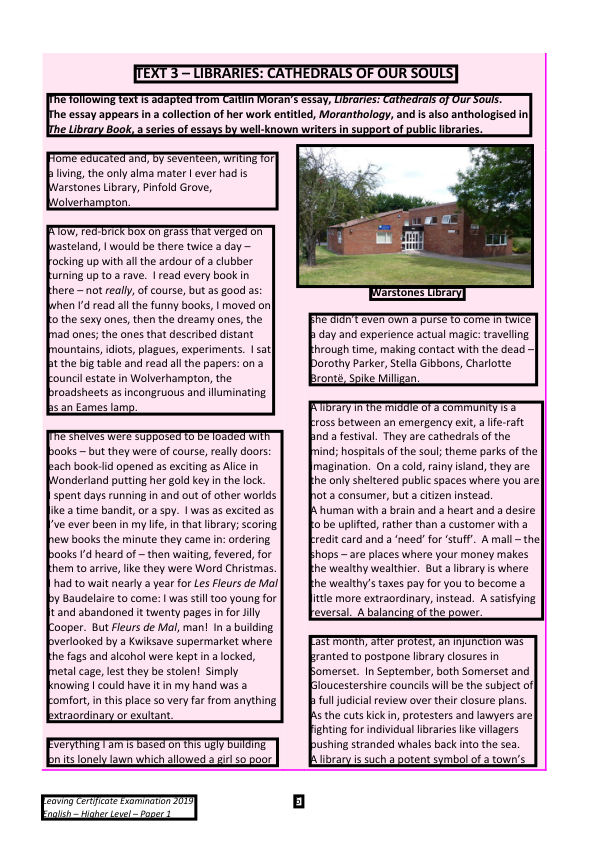

In [ ]:
from time import sleep
median_dy0 = find_y0_dL(page_df)
median_w   = page_df.w.median()
eps_y0     = median_dy0*1.15
eps_x0     = median_w*0.5

dirs = (("y0",eps_y0), ("x0",eps_x0))
i_dir = 0
page_df["cluster"]=0
n_labels=1

for n_loop in range(3):
    # assin the direction and cluster numbers for this round of scanning
    dir = dirs[i_dir][0] ; eps = dirs[i_dir][1]
    clust_id = len(np.unique(page_df.cluster))
    print(f"Scanning in {dir}")

    # Loop over all current clusters and break up in dir
    for i_clust in np.unique(page_df.cluster):

        temp_df = page_df[page_df.cluster==i_clust].copy()

        scan = DBSCAN(eps=eps, min_samples=1)
        scan.fit(temp_df[[dir]])

        labels = scan.labels_
        n_labels = len(np.unique(labels) )

        if n_labels ==1:
            continue
        
        labels[labels==0] = i_clust
        for i in range(1, n_labels):
            labels[labels==i]=clust_id
            clust_id +=1
        temp_df.cluster = labels
        page_df.loc[temp_df.index, "cluster"] = temp_df.cluster
            

    i_dir = 1 if i_dir==0 else 0

    rectangies = get_category_boxes(page_df, 'cluster')
    img = get_bbox_page_image(doc, 6, rectangies,color=(0.0,0,0.0))
    display(img)
    sleep(5)

In [80]:
page_df["cluster"].value_counts()

cluster
7     20
11    15
3     13
12     9
10     5
4      4
13     3
9      2
8      2
2      1
6      1
5      1
14     1
Name: count, dtype: int64

# Scan using bbox distances

In [16]:
from pdf_scraper.general_utils import bbox_vert_dist

In [17]:
dff = page_df[['x0', 'y0', 'x1', 'y1',  'text', 'font_size', 'image', 'counts']].copy()
dff.head()

x0     y0     x1     y1  \
0 135.24  65.98 456.68  82.00   
1  47.94  94.50 510.43 106.50   
2  47.94 109.14 530.83 121.14   
3  47.94 123.78 485.53 135.78   
4 297.72 145.62 532.50 286.62   

                                                                                                 text  \
0                                                        TEXT 3 – LIBRARIES: CATHEDRALS OF OUR SOULS    
1    The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.      
2  The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in    
3         The Library Book, a series of essays by well‐known writers in support of public libraries.    
4                                                                                                 NaN   

   font_size  image  counts  
0      16.02      0    0.00  
1      12.00      0    0.00  
2      12.00      0    0.00  
3      12.00      0    0.00  
4        NaN      1     NaN

In [18]:
def df_vert_next_row_dist(y0, y1, y0_next, y1_next):
    """Vectorized vertical distance between two line segments."""
    overlap = np.maximum(y0, y0_next) <= np.minimum(y1, y1_next)
    dist = np.where(overlap, 0.0, np.minimum(np.abs(y1 - y0_next), np.abs(y1_next - y0)))
    return dist

# Vectorized version using shift()
dff["dL"] = df_vert_next_row_dist(dff.y0, dff.y1, dff.y0.shift(-1), dff.y1.shift(-1) )
dff["dy0"] = dff.y0.shift(-1) - dff.y0
dff.head()


x0     y0     x1     y1  \
0 135.24  65.98 456.68  82.00   
1  47.94  94.50 510.43 106.50   
2  47.94 109.14 530.83 121.14   
3  47.94 123.78 485.53 135.78   
4 297.72 145.62 532.50 286.62   

                                                                                                 text  \
0                                                        TEXT 3 – LIBRARIES: CATHEDRALS OF OUR SOULS    
1    The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.      
2  The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in    
3         The Library Book, a series of essays by well‐known writers in support of public libraries.    
4                                                                                                 NaN   

   font_size  image  counts    dL   dy0  
0      16.02      0    0.00 12.50 28.51  
1      12.00      0    0.00  2.64 14.64  
2      12.00      0    0.00  2.64 14.64  
3      12.00      0    0.00  9.84 21.84  
4        NaN      1     NaN  0.00  7.50

median dy0  14.64                          median dL   2.64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
dy0                                 11     | dL                                  9      | 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
14.64                               44.7 % | 2.64                                44.7 % | 
0.0                                 36.8 % | 0.0                                 39.5 % | 
14.7                                7.9  % | 2.7                                 7.9  % | 
21.84                               1.3  % | 12.5                                1.3  % | 
28.51                               1.3  % | 9.84                                1.3  % | 
29.28                               1.3  % | 17.28                      

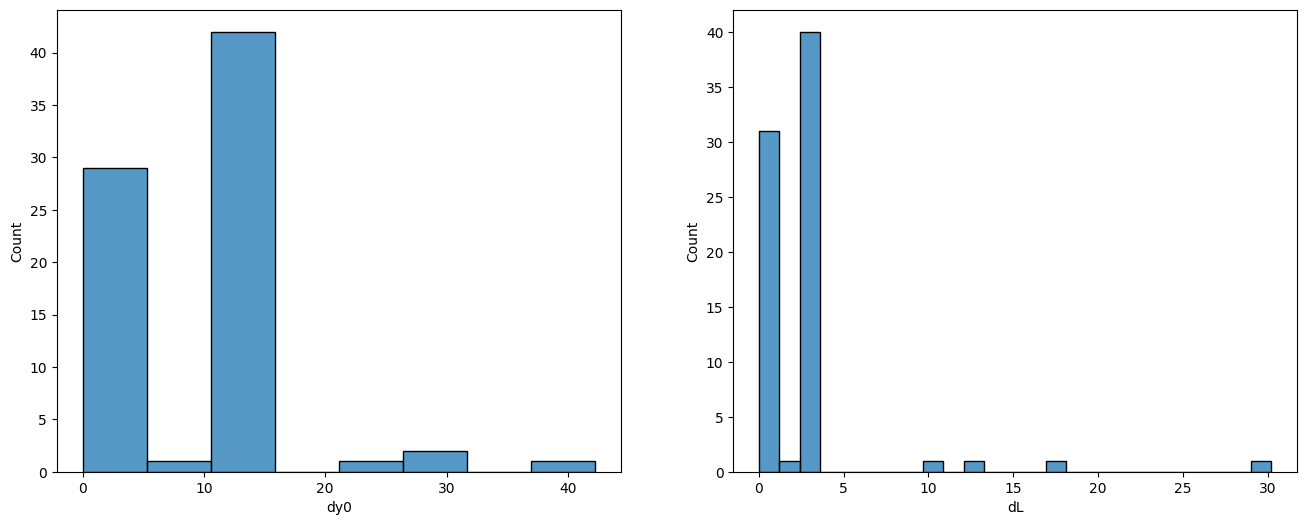

In [19]:
from pdf_scraper.data_sci_utils import examine_value_counts
dy0s = dff.dy0.dropna()
dy0_median =  dy0s[dy0s !=0].median()
dLs = dff.dL.dropna()
dL_median = dLs[dLs!=0].median()

print(f"median dy0 {dy0_median:6.2f}                          median dL {dL_median:6.2f}")
examine_value_counts(pd.concat([dy0s.round(2),dLs.round(2)],axis=1),["dy0","dL"])

fig, axes = plt.subplots(1,2,figsize=(16,6))
sns.histplot(dy0s, ax=axes[0]);
sns.histplot(dLs.round(2), ax=axes[1]);


## bbox end-to-end y-clustering

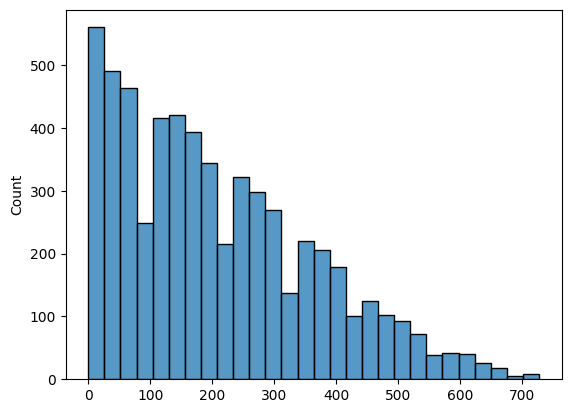

In [20]:
from sklearn.metrics import pairwise_distances

def df_vert_dist(row1, row2):
    y0, y1 = row1
    y0_next, y1_next = row2

    overlap = max(y0, y0_next) <= min(y1, y1_next)
    if overlap:
        return 0.0
    return min(abs(y1 - y0_next), abs(y1_next - y0))

dist_matrix = pairwise_distances(dff[["y0", "y1"]].values, metric=df_vert_dist)
mask = ~np.eye(dist_matrix.shape[0], dtype=bool)
vals = dist_matrix[mask]  
sns.histplot(vals.round(2).flatten());

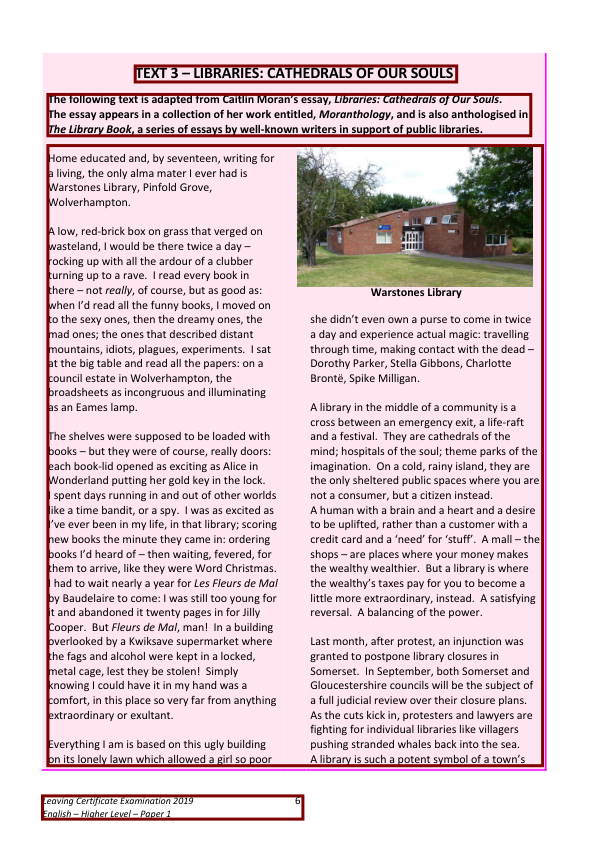

In [21]:
scan = DBSCAN(eps=dL_median*1.15, min_samples=1,metric=df_vert_dist)
scan.fit(dff[["y0","y1"]])
dff["y_cluster"] = scan.labels_

rectangies = get_category_boxes(dff, 'y_cluster')
y_img = get_bbox_page_image(doc, 6, rectangies,color=(0.5,0,0.0))
display(y_img)

## end to end x-clustering

In [22]:
dfx = dff.sort_values(by="x0")
dfx.head(6)

x0     y0     x1     y1  \
74 42.54 795.94 195.86 806.92   
76 42.54 809.08 173.38 819.10   
1  47.94  94.50 510.43 106.50   
2  47.94 109.14 530.83 121.14   
7  47.94 182.40 214.81 194.40   
6  47.94 167.76 250.21 179.76   

                                                                                                  text  \
74                                                               Leaving Certificate Examination 2019    
76                                                                   English – Higher Level – Paper 1    
1     The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.      
2   The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in    
7                                                                   Warstones Library, Pinfold Grove,    
6                                                         a living, the only alma mater I ever had is    

    font_size  image  counts   dL   dy0  y_cluster  
74      10.02      0    1.00 0.00  0.00          3  
76      10.02      0    0.00  NaN   NaN          3  
1       12.00      0    0.00 2.64 14.64          1  
2       12.00      0    0.00 2.64 14.64          1  
7       12.00      0    0.00 2.64 14.64          2  
6       12.00      0    0.00 2.64 14.64          2

In [23]:
def df_vert_next_row_dist(y0, y1, y0_next, y1_next):
    """Vectorized vertical distance between two line segments."""
    overlap = np.maximum(y0, y0_next) <= np.minimum(y1, y1_next)
    dist = np.where(overlap, 0.0, np.minimum(np.abs(y1 - y0_next), np.abs(y1_next - y0)))
    return dist

dfx = dfx.sort_values(by="x0")
# Vectorized version using shift()
dfx["dX"] = df_vert_next_row_dist(dfx.x0, dfx.x1, dfx.x0.shift(-1), dfx.x1.shift(-1) )
dfx["dx0"] = dfx.x0.shift(-1) - dfx.x0
dfx.head()

x0     y0     x1     y1  \
74 42.54 795.94 195.86 806.92   
76 42.54 809.08 173.38 819.10   
1  47.94  94.50 510.43 106.50   
2  47.94 109.14 530.83 121.14   
7  47.94 182.40 214.81 194.40   

                                                                                                  text  \
74                                                               Leaving Certificate Examination 2019    
76                                                                   English – Higher Level – Paper 1    
1     The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.      
2   The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in    
7                                                                   Warstones Library, Pinfold Grove,    

    font_size  image  counts   dL   dy0  y_cluster   dX  dx0  
74      10.02      0    1.00 0.00  0.00          3 0.00 0.00  
76      10.02      0    0.00  NaN   NaN          3 0.00 5.40  
1       12.00      0    0.00 2.64 14.64          1 0.00 0.00  
2       12.00      0    0.00 2.64 14.64          1 0.00 0.00  
7       12.00      0    0.00 2.64 14.64          2 0.00 0.00

 - Let's look at the distributions of the full neighbour distances
 - Find the characteristic dX to use in the eps scan
 - do the eps scan

 - return to hierarchical clustering code.

 - clean all code and implement on captions.

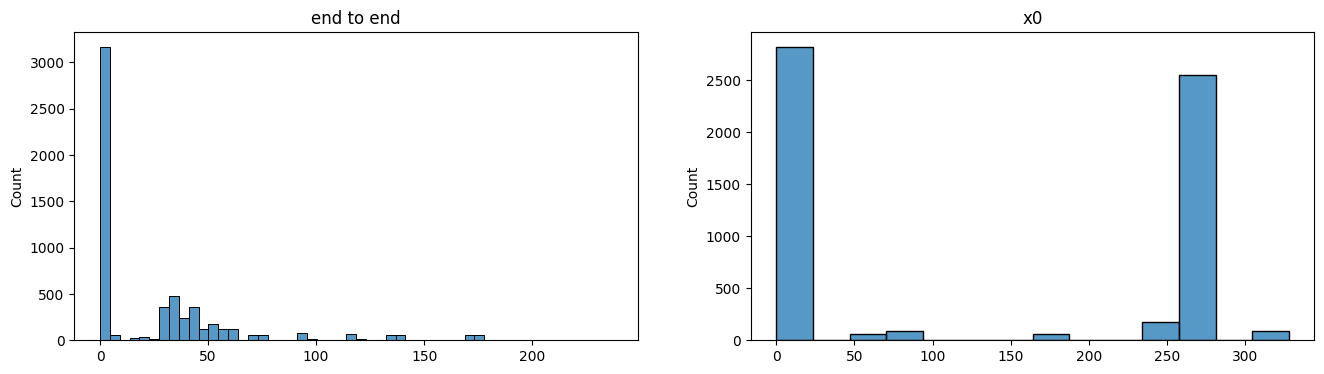

In [33]:
def df_vert_dist(row1, row2):
    y0, y1 = row1
    y0_next, y1_next = row2

    overlap = max(y0, y0_next) <= min(y1, y1_next)
    if overlap:
        return 0.0
    return min(abs(y1 - y0_next), abs(y1_next - y0))

dist_matrix = pairwise_distances(dfx[["x0", "x1"]].values, metric=df_vert_dist)
mask = ~np.eye(dist_matrix.shape[0], dtype=bool)
vals = dist_matrix[mask]   

dist_matrix2 = pairwise_distances(dfx[["x0"]].values, metric="euclidean")
mask2 = ~np.eye(dist_matrix2.shape[0], dtype=bool)
vals2 = dist_matrix2[mask2]   

fig, axes = plt.subplots(1, 2 , figsize=(16,4))
sns.histplot(vals.round(2).flatten(),ax=axes[0]);
axes[0].set_title("end to end");
sns.histplot(vals2.round(2).flatten(),ax=axes[1]);
axes[1].set_title("x0");

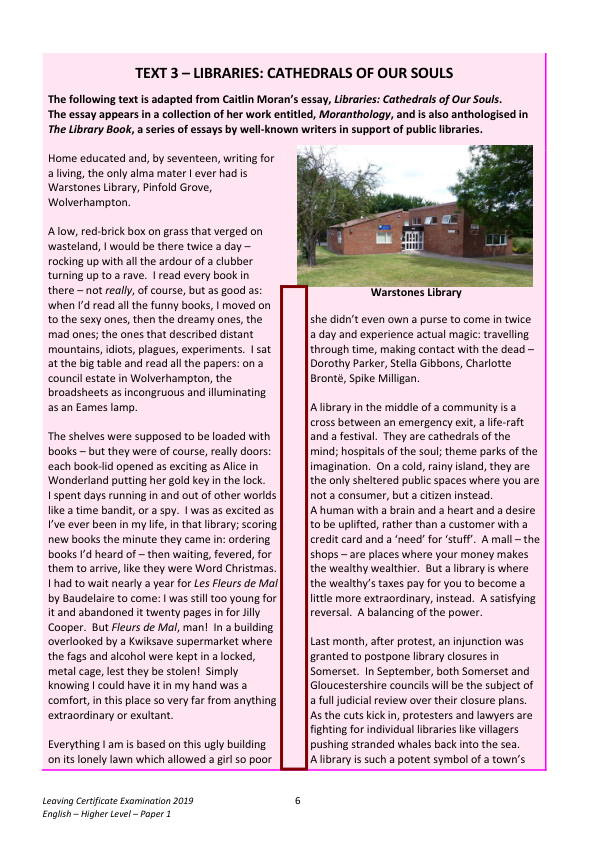

Box end to end is 25.0


In [49]:
x0 = middle-16
x1 = middle+9

y0 = page_images[0]["bbox"][3]
y1 = dff.y1.max() -50

rectangies = [Rect(x0,y0,x1,y1)]
img = get_bbox_page_image(doc, 6, rectangies,color=(0.5,0,0.0))
display(img)

eps_x = x1-x0
print(f"Box end to end is {eps_x}")

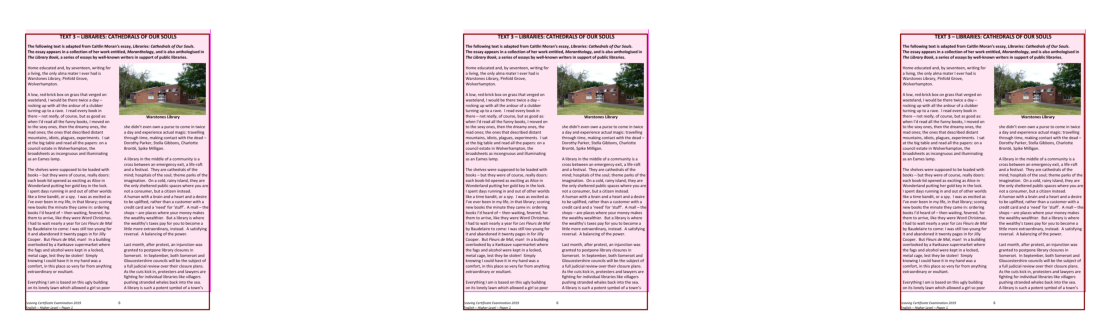

In [56]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
for i, eps_scale in enumerate([0.1, 0.24, 0.5]):
    scan = DBSCAN(eps=eps_x*eps_scale, min_samples=1,metric=df_vert_dist)
    scan.fit(dff[["x0","x1"]])
    dff["x_cluster"] = scan.labels_
    
    rectangies = get_category_boxes(dff, 'x_cluster')
    x_img = get_bbox_page_image(doc, 6, rectangies,color=(0.5,0,0.0))
    axes[i].imshow(x_img); axes[i].axis("off");

- This is because the bbox of, for example, the subtitle covers the entire figure.
  - you need to partition by y first.